# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

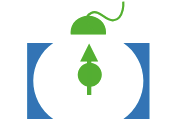

In [2]:
# initial state is a thermal state
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [ ]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [5]:
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation

initial_params = {
    "POVM": [0.1, -3 * jnp.pi / 2],
}
result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=rho_cav,
    parameterized_gates=[povm_measure_operator],
    measurement_indices=[0],
    initial_params=initial_params,
    num_time_steps=5,
    mode="nn",
    goal="purity",
    optimizer="adam",
    max_iter=100,
    convergence_threshold=1e-20,
    learning_rate=0.01,
    type="density",
    batch_size=10,
)

Iteration 0, Loss: 0.884457
Iteration 10, Loss: 0.978385
Iteration 20, Loss: 1.013752
Iteration 30, Loss: 1.019251
Iteration 40, Loss: 1.326805
Iteration 50, Loss: 1.249736
Iteration 60, Loss: 1.333131
Iteration 70, Loss: 1.015745
Iteration 80, Loss: 1.001107
Iteration 90, Loss: 1.281367


In [6]:
result

FgResult(optimized_trainable_parameters={'initial_params': [Array([ 0.28833872, -4.79210501], dtype=float64)], 'rnn_params': {'params': {'Dense_0': {'bias': Array([3.062298 , 3.0789442], dtype=float32), 'kernel': Array([[-0.50947946, -0.00955151],
       [-0.41195154, -0.3916563 ],
       [ 0.2202907 ,  0.34981662],
       [ 0.38034344,  0.13680854],
       [ 0.22650963,  0.38782585],
       [-0.32610607,  0.27314213],
       [-0.14363177,  0.15212087],
       [ 0.42776352,  0.13878012],
       [-0.51317114, -0.5641353 ],
       [-0.17018618, -0.06460462],
       [-0.31447816, -0.42278194],
       [-0.36685508, -0.03093236],
       [-0.38357723, -0.33297232],
       [ 0.05831265, -0.34457576],
       [ 0.45810774,  0.5572649 ],
       [ 0.30704364, -0.5202585 ],
       [ 0.31456345,  0.60070246],
       [ 0.35888755,  0.11585622],
       [-0.11221014, -0.38835517],
       [ 0.35398635,  0.40166387],
       [ 0.27387515,  0.14680228],
       [-0.29714668, -0.05240448],
       [ 0.081573

In [7]:
print(result.final_fidelity)

None


In [8]:
print(result.final_state)

[[[ 4.86861512e-01+0.j -4.18190408e-02+0.j -5.50526314e-02+0.j ...
   -2.37679659e-03+0.j -2.30320793e-03+0.j -4.80098211e-03+0.j]
  [-4.18190408e-02+0.j  3.42725702e-01+0.j -6.73291936e-02+0.j ...
   -1.49947336e-03+0.j -1.39350242e-03+0.j -2.36911203e-03+0.j]
  [-5.50526314e-02+0.j -6.73291936e-02+0.j  2.48662913e-02+0.j ...
    5.28827082e-04+0.j  4.83227614e-04+0.j  1.10445080e-03+0.j]
  ...
  [-2.37679659e-03+0.j -1.49947336e-03+0.j  5.28827082e-04+0.j ...
    4.18022089e-05+0.j  3.74541244e-05+0.j  4.91474805e-05+0.j]
  [-2.30320793e-03+0.j -1.39350242e-03+0.j  4.83227614e-04+0.j ...
    3.74541244e-05+0.j  3.62880771e-05+0.j  5.00781496e-05+0.j]
  [-4.80098211e-03+0.j -2.36911203e-03+0.j  1.10445080e-03+0.j ...
    4.91474805e-05+0.j  5.00781496e-05+0.j  9.33105293e-05+0.j]]

 [[ 5.88207684e-03+0.j  7.49253520e-03+0.j  5.56003617e-02+0.j ...
   -1.86795070e-04+0.j -3.38114378e-04+0.j -7.86926568e-05+0.j]
  [ 7.49253520e-03+0.j  2.20640248e-02+0.j  1.36158537e-01+0.j ...
   -4.91

In [9]:
result.optimized_trainable_parameters['rnn_params']

{'params': {'Dense_0': {'bias': Array([3.062298 , 3.0789442], dtype=float32),
   'kernel': Array([[-0.50947946, -0.00955151],
          [-0.41195154, -0.3916563 ],
          [ 0.2202907 ,  0.34981662],
          [ 0.38034344,  0.13680854],
          [ 0.22650963,  0.38782585],
          [-0.32610607,  0.27314213],
          [-0.14363177,  0.15212087],
          [ 0.42776352,  0.13878012],
          [-0.51317114, -0.5641353 ],
          [-0.17018618, -0.06460462],
          [-0.31447816, -0.42278194],
          [-0.36685508, -0.03093236],
          [-0.38357723, -0.33297232],
          [ 0.05831265, -0.34457576],
          [ 0.45810774,  0.5572649 ],
          [ 0.30704364, -0.5202585 ],
          [ 0.31456345,  0.60070246],
          [ 0.35888755,  0.11585622],
          [-0.11221014, -0.38835517],
          [ 0.35398635,  0.40166387],
          [ 0.27387515,  0.14680228],
          [-0.29714668, -0.05240448],
          [ 0.08157367,  0.08613869],
          [ 0.08578405, -0.27094242],


In [10]:
# 0.8119213228423314
print(result.final_purity)

0.7273437300284704


In [11]:
from feedback_grape.utils.purity import purity

print("initial purity:", purity(rho=rho_cav))
for i, state in enumerate(result.final_state):
    print(f"Purity of state {i}:", purity(rho=state))

initial purity: 0.20000208604889932
Purity of state 0: 0.40479791656779196
Purity of state 1: 0.9282906475356526
Purity of state 2: 0.46707475768234846
Purity of state 3: 0.6580169686561185
Purity of state 4: 0.9038700840436446
Purity of state 5: 0.33923916828436507
Purity of state 6: 0.9282906475356526
Purity of state 7: 0.8361169418918409
Purity of state 8: 0.9038700840436446
Purity of state 9: 0.9038700840436446


In [12]:
result.returned_params

[[Array([[ 0.28833872, -4.79210501],
         [ 0.28833872, -4.79210501],
         [ 0.28833872, -4.79210501],
         [ 0.28833872, -4.79210501],
         [ 0.28833872, -4.79210501],
         [ 0.28833872, -4.79210501],
         [ 0.28833872, -4.79210501],
         [ 0.28833872, -4.79210501],
         [ 0.28833872, -4.79210501],
         [ 0.28833872, -4.79210501]], dtype=float64)],
 [Array([[4.14372193, 5.00559007],
         [4.14372193, 5.00559007],
         [2.26136728, 0.99416435],
         [4.14372193, 5.00559007],
         [4.14372193, 5.00559007],
         [2.26136728, 0.99416435],
         [4.14372193, 5.00559007],
         [4.14372193, 5.00559007],
         [4.14372193, 5.00559007],
         [4.14372193, 5.00559007]], dtype=float64)],
 [Array([[ 5.00037442,  5.89200083],
         [ 5.00037442,  5.89200083],
         [-1.42010715, -1.24881463],
         [ 5.53547614,  3.81064551],
         [ 5.53547614,  3.81064551],
         [ 3.68271327,  3.7206052 ],
         [ 5.00037442,

In [13]:
print(jax.random.PRNGKey(9))
time_step_keys = jax.random.split(jax.random.PRNGKey(9), 5)
print(time_step_keys)
for key in time_step_keys:
    print(jax.random.uniform(key))

[0 9]
[[2822284597 2722679661]
 [ 143080583 4281670255]
 [2676565412 4109519897]
 [1877436067 1979300842]
 [3339921199 4267639851]]
0.16232149317805766
0.07829857808883056
0.8422083576204116
0.23698051656885277
0.33005660981143814


In [14]:
from feedback_grape.fgrape import povm
import random

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))

rand_num = random.randint(1, 50)

time_step_keys = jax.random.split(jax.random.PRNGKey(rand_num), time_steps)
for i in range(time_steps):
    params = result.returned_params[i][0]
    print(f"params for time step {i}:", params[0])
    rho, _, _ = povm(rho, povm_measure_operator, params[0], time_step_keys[i])
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.20000208604889932
params for time step 0: [ 0.28833872 -4.79210501]
purity of rho after time step 0 0.3258863251208345
params for time step 1: [4.14372193 5.00559007]
purity of rho after time step 1 0.4257679156567149
params for time step 2: [5.00037442 5.89200083]
purity of rho after time step 2 0.5145051508985861
params for time step 3: [5.27289248 6.13155621]
purity of rho after time step 3 0.6082001403446702
params for time step 4: [5.40389471 6.27462533]
purity of rho after time step 4 0.582102582926207


In [15]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.0973540364721641
0.9026459635278362


### Check stash for replacement of dict implementation

In [16]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 6.78098130e-01+0.j -1.33312196e-01+0.j -5.70284366e-02+0.j
  -1.16023578e-02+0.j -3.85044979e-02+0.j -3.32810265e-02+0.j
  -4.62182190e-02+0.j -9.37864553e-03+0.j -1.62418737e-04+0.j
  -1.38913768e-02+0.j -1.57216164e-02+0.j -1.12937380e-02+0.j
  -4.85400130e-03+0.j -9.41170897e-03+0.j -1.03427472e-02+0.j
  -6.94297001e-03+0.j -7.38120763e-03+0.j -6.37865217e-03+0.j
  -2.85297890e-03+0.j -4.51687133e-03+0.j -8.65051228e-03+0.j
  -7.48737132e-03+0.j -7.38658692e-03+0.j -5.92332149e-03+0.j
  -3.47643006e-03+0.j -4.53472028e-03+0.j -5.52505303e-03+0.j
  -5.78617964e-05+0.j -4.41189765e-03+0.j -4.43644787e-03+0.j]
 [-1.33312196e-01+0.j  2.92761423e-02+0.j  1.63815109e-02+0.j
   2.77575127e-02+0.j  3.65333439e-04+0.j  3.88868279e-03+0.j
   9.04377976e-03+0.j -2.75596047e-04+0.j -2.00451433e-03+0.j
   1.70169155e-03+0.j  2.45349524e-03+0.j  1.50627674e-03+0.j
   3.50511021e-05+0.j  1.26626642e-03+0.j  1.53994600e-03+0.j
   9.40698781e-04+0.j  1

In [17]:
print("Final state from solver:", result.final_state)

Final state from solver: [[[ 4.86861512e-01+0.j -4.18190408e-02+0.j -5.50526314e-02+0.j ...
   -2.37679659e-03+0.j -2.30320793e-03+0.j -4.80098211e-03+0.j]
  [-4.18190408e-02+0.j  3.42725702e-01+0.j -6.73291936e-02+0.j ...
   -1.49947336e-03+0.j -1.39350242e-03+0.j -2.36911203e-03+0.j]
  [-5.50526314e-02+0.j -6.73291936e-02+0.j  2.48662913e-02+0.j ...
    5.28827082e-04+0.j  4.83227614e-04+0.j  1.10445080e-03+0.j]
  ...
  [-2.37679659e-03+0.j -1.49947336e-03+0.j  5.28827082e-04+0.j ...
    4.18022089e-05+0.j  3.74541244e-05+0.j  4.91474805e-05+0.j]
  [-2.30320793e-03+0.j -1.39350242e-03+0.j  4.83227614e-04+0.j ...
    3.74541244e-05+0.j  3.62880771e-05+0.j  5.00781496e-05+0.j]
  [-4.80098211e-03+0.j -2.36911203e-03+0.j  1.10445080e-03+0.j ...
    4.91474805e-05+0.j  5.00781496e-05+0.j  9.33105293e-05+0.j]]

 [[ 5.88207684e-03+0.j  7.49253520e-03+0.j  5.56003617e-02+0.j ...
   -1.86795070e-04+0.j -3.38114378e-04+0.j -7.86926568e-05+0.j]
  [ 7.49253520e-03+0.j  2.20640248e-02+0.j  1.3615

In [18]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [19]:
import jax.numpy as jnp
import jax

initial_params = {
    "POVM": [0.1, 0.2],
    "test": [0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1],
}


# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [20]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]


In [21]:
jnp.array([0.1, 0.2, 0.2])

Array([0.1, 0.2, 0.2], dtype=float64)

In [22]:
batch_size = 2

In [23]:
rho_final_batched = jnp.repeat(jnp.expand_dims(rho_cav, 0), batch_size, axis=0)

In [24]:
rho_final_batched.shape

(2, 30, 30)

In [25]:
parent_key = jax.random.PRNGKey(0)
print(parent_key.shape)
rng_keys = jax.random.split(parent_key)

(2,)


In [26]:
rng_keys[0].shape

(2,)

In [27]:
print(jnp.array([1, 3]) * -jnp.array([2, 2]))

[-2 -6]


In [28]:
jax.random.PRNGKey(10)

Array([ 0, 10], dtype=uint32)

In [29]:
measurement = jnp.where(0.1 < 0.3, 1, -1)
print(measurement.item())

1


In [40]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [ ]:
initial_params = {
    "qubit_unitary": [0.1, 0.1],
    "qubit_cavity_unitary": [0.2, 0.2],
}
param_constraints = [[[0, 0.5]], [[1.0, 1.5]], [[1.5, 2.0]], [[2.0, 2.5]]]

In [45]:
def construct_ragged_row(
    num_of_rows, num_of_columns, param_constraints, rng_key
):
    res = []
    for i in range(num_of_rows):
        row = []
        for j in range(num_of_columns):
            rng_key, subkey = jax.random.split(rng_key)
            print(j)
            print(param_constraints[j])
            val = jax.random.uniform(
                subkey,
                shape=(),
                minval=param_constraints[j][0]
                if len(param_constraints[j]) != 0
                else 0.0,
                maxval=param_constraints[j][1]
                if len(param_constraints[j]) != 0
                else jnp.pi,
            )
            row.append(val)
        res.append(jnp.array(row))
    return res

In [46]:
h_initial_state = None
rnn_model = None
# step 1: initialize the parameters
num_of_columns = 4
num_of_sub_lists = 1 * 5
F = []
param_constraints_reshaped = jnp.array(param_constraints).reshape(-1, 2)
# construct ragged lookup table
row_key = jax.random.PRNGKey(0)
for i in range(1, num_of_sub_lists + 1):
    row_key, _ = jax.random.split(row_key)
    F.append(
        construct_ragged_row(
            num_of_rows=2**i,
            num_of_columns=num_of_columns,
            param_constraints=param_constraints_reshaped,
            rng_key=row_key,
        )
    )
# step 2: pad the arrays to have the same number of rows
min_num_of_rows = 2 ** len(F)
for i in range(len(F)):
    if len(F[i]) < min_num_of_rows:
        zeros_arrays = [
            jnp.zeros((num_of_columns,), dtype=jnp.float64)
            for _ in range(min_num_of_rows - len(F[i]))
        ]
        F[i] = F[i] + zeros_arrays

F

0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1.  1.5]
0
[0.  0.5]
1
[1.  1.5]
2
[0.  0.5]
3
[1

[[Array([0.33559649, 1.17583317, 0.07987065, 1.48053433], dtype=float64),
  Array([0.11240873, 1.14456978, 0.07282654, 1.42680755], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0.,